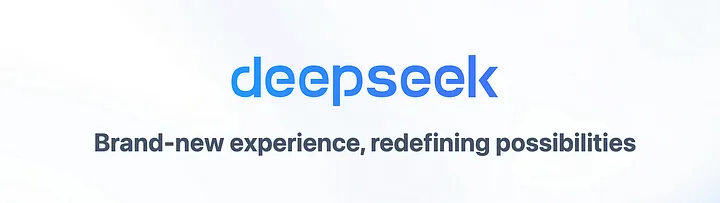

#Introduction
In this guide, we’ll walk through the process of fine-tuning DeepSeek LLM using Supervised Fine-Tuning (SFT) with Hugging Face datasets, providing a step-by-step code walkthrough for training on a domain-specific dataset. We will also discuss the loss function used, why a subset of data was used, and how LoRA (Low-Rank Adaptation) enables memory-efficient fine-tuning.

## 1. Check GPU Availability
Make sure Google Colab is using a GPU.

In [ ]:
import torch
torch.cuda.is_available()

True

If this returns True, you're good to go! If not, go to Runtime > Change runtime type > GPU.

# Install Required Libraries
Run this command to install transformers, torch, and accelerate.

In [ ]:
#download required dependencies in drive to directly import for later use
from google.colab import drive
drive.mount('/content/drive') #this will connect this note book to colab

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install -U torch==2.5.1 transformers datasets accelerate peft bitsandbytes --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 608.1 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1

In [ ]:
#!pip install bitsandbytes-cuda11.8

ERROR: Could not find a version that satisfies the requirement bitsandbytes-cudaXXX (from versions: none)
ERROR: No matching distribution found for bitsandbytes-cudaXXX


* 'torch': PyTorch, a deep learning framework.
* 'transformers': Hugging Face Transformers library for NLP and generative AI.
* 'datasets': Hugging Face Datasets library for loading and processing large datasets.
* 'accelerate': Helps optimize model training and inference across different hardware.
* 'peft': Parameter-Efficient Fine-Tuning library for efficient model adaptation.
* 'bitsandbytes': 8-bit and 4-bit quantization library for efficient deep learning.

# 3. Load DeepSeek LLM from Hugging Face

Load the model with LoRA (Low-Rank Adaptation) for efficient fine-tuning.

In [ ]:
import torch #This imports the PyTorch library, which is widely used for deep learning and tensor computation.
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

model_name = "deepseek-ai/deepseek-llm-7b-base"

# Configure 4-bit quantization (Reduces model size by 8x)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16  # Use float16 for faster computation
)

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Explicitly move the model to the CUDA device
model.to('cuda')  # Add this line

# Apply LoRA for memory-efficient fine-tuning
lora_config = LoraConfig(
    r=8,  # Low-rank adaptation size
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to attention layers
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

print("✅ DeepSeek LLM Loaded with LoRA and 4-bit Precision!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

trainable params: 3,932,160 || all params: 6,914,297,856 || trainable%: 0.0569
✅ DeepSeek LLM Loaded with LoRA and 4-bit Precision!


# 4. Load and Preprocess the Amazon Dataset

Download the Amazon sentiment dataset and prepare it for causal language modeling.



In [ ]:
from datasets import load_dataset
dataset = load_dataset("amazon_polarity")
# Display dataset structure and a few samples
print("Dataset Structure:")
print(dataset)

print("Sample Data:")
print(dataset["train"][0])  # First sample
print(dataset["train"][1])  # Second sample

README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})
Sample Data:
{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}
{'label': 1, 'title': 'The best soundtrack ever to anything.', 'content': "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music i

### Tokenize Dataset

In [ ]:
def tokenize_function(examples):
    inputs = tokenizer(
        examples["content"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    inputs["labels"] = inputs["input_ids"].copy()  # Use input_ids as labels for causal LM
    return inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True) #here we are using our data

# Verify tokenized sample
print("Tokenized Sample with Labels:")
print(tokenized_datasets["train"][0])

Map:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

Tokenized Sample with Labels:
{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', 'input_ids': [100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100

In [ ]:
# Save the tokenized dataset to disk (to save time)
tokenized_datasets.save_to_disk("/content/drive/MyDrive/Colab Notebooks/Fine tuning deep seek/tokenized_datasets")

Saving the dataset (0/52 shards):   0%|          | 0/3600000 [00:00<?, ? examples/s]

Saving the dataset (0/6 shards):   0%|          | 0/400000 [00:00<?, ? examples/s]

In [ ]:
import shutil

shutil.rmtree("/content/drive/MyDrive/Colab Notebooks/Fine tuning deep seek/tokenized_datasets")

# 5. Set Training Parameterss

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=True,
)

print("✅ WandB Disabled!")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ WandB Disabled!


# Get sample Data

To speed up the training

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

# 5. Initialize Trainer and Train

Set up the Trainer and start fine-tuning.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset.remove_columns(["title", "content"]),  # Remove text-based columns
    eval_dataset=small_test_dataset.remove_columns(["title", "content"]),
)

print("🚀 Trainer Initialized!")


🚀 Trainer Initialized!


In [ ]:
torch.cuda.empty_cache()
print("✅ Cleared CUDA Cache")

✅ Cleared CUDA Cache


# 6. Fine-Tune DeepSeek LLM

In [ ]:
print("🚀 Starting Fine-Tuning...")
trainer.train()

🚀 Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss
0,No log,No log


TrainOutput(global_step=62, training_loss=1.4257881410660282, metrics={'train_runtime': 893.5748, 'train_samples_per_second': 0.56, 'train_steps_per_second': 0.069, 'total_flos': 9896307481116672.0, 'train_loss': 1.4257881410660282, 'epoch': 0.992})

#7. Run Predictions with the Fine-Tuned Model
Now that we have fine-tuned DeepSeek LLM, let's generate predictions for new text inputs.



In [ ]:
!pip install langchain

In [ ]:
from langchain import PromptTemplate

sentiment_prompt = PromptTemplate(
    input_variables=["review_text"],
    template="""
You are an AI sentiment analysis model trained to analyze user reviews and generate structured responses.

### **Strict Guidelines:**
- Provide **only sentiment-related analysis** of the review.
- Do **NOT** generate speculative content.
- The response **MUST** follow a structured format.

---

## **📌 Sentiment Analysis**

### **1️⃣ Overall Sentiment**
- <Clearly state whether the sentiment is Positive, Negative, or Neutral.>

### **2️⃣ Key Sentiment Drivers**
- <Summarize the main aspects contributing to this sentiment (e.g., product quality, storytelling, cinematography).>

### **3️⃣ Emotional Tone & Intensity**
- <Describe the emotional tone (e.g., enthusiastic, disappointed, indifferent) and its intensity (e.g., strong, moderate, weak).>

---
"""
)

In [ ]:
# Function to generate structured sentiment analysis
def generate_sentiment_analysis(review_text):
    input_text = f"Review: {review_text}\n\n{sentiment_prompt}"

    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    # Generate response
    outputs = model.generate(**inputs, max_length=700, pad_token_id=tokenizer.eos_token_id)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the relevant structured response
    match = re.search(r"### \*\*📌 Sentiment Analysis\*\*([\s\S]*)", decoded_output)

    return match.group(0).strip() if match else "Failed to extract sentiment analysis. Please try again."

# Create Gradio Interface
interface = gr.Interface(
    fn=generate_sentiment_analysis,  # Function to process input
    inputs=gr.Textbox(lines=5, placeholder="Enter your review here..."),  # User input field
    outputs=gr.Markdown(),  # Display structured sentiment in markdown format
    title="🔍 Sentiment Analysis AI",
    description="Enter a review and get a structured sentiment analysis."
)

# Launch Gradio app
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e063e13debb75a7725.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 7. Save the model locally

In [ ]:
#check model directory either it is safe or not
!ls -l model_directory

#If the directory exists, it should show files like:
#> config.json  pytorch_model.bin  tokenizer.json  tokenizer_config.json  ...

total 22724
-rw-r--r-- 1 root root      831 Feb  5 08:34 adapter_config.json
-rw-r--r-- 1 root root 15744552 Feb  5 08:34 adapter_model.safetensors
-rw-r--r-- 1 root root     5106 Feb  5 08:34 README.md
-rw-r--r-- 1 root root      482 Feb  5 08:34 special_tokens_map.json
-rw-r--r-- 1 root root     3079 Feb  5 08:34 tokenizer_config.json
-rw-r--r-- 1 root root  7503656 Feb  5 08:34 tokenizer.json


In [ ]:
#if not save the model in colab work space
model.save_pretrained("model_directory")
tokenizer.save_pretrained("model_directory")

#to verify the saved model
!ls -l model_directory

NameError: name 'model' is not defined

# 8. Graphical User interface

In [ ]:
# Function to generate structured sentiment analysis
def generate_sentiment_analysis(review_text):
    input_text = f"Review: {review_text}\n\n{sentiment_prompt}"

    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    # Generate response
    outputs = model.generate(**inputs, max_length=700, pad_token_id=tokenizer.eos_token_id)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the relevant structured response
    # match = re.search(r"### \*\*📌 Sentiment Analysis\*\*([\s\S]*)", decoded_output)

    return match.group(0).strip() if match else "Failed to extract sentiment analysis. Please try again."

# Create Gradio Interface
interface = gr.Interface(
    fn=generate_sentiment_analysis,  # Function to process input
    inputs=gr.Textbox(lines=5, placeholder="Enter your review here..."),  # User input field
    outputs=gr.Markdown(),  # Display structured sentiment in markdown format
    title="🔍 Sentiment Analysis AI",
    description="Enter a review and get a structured sentiment analysis."
)

# Launch Gradio app
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://00b6324f201d9f22de.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


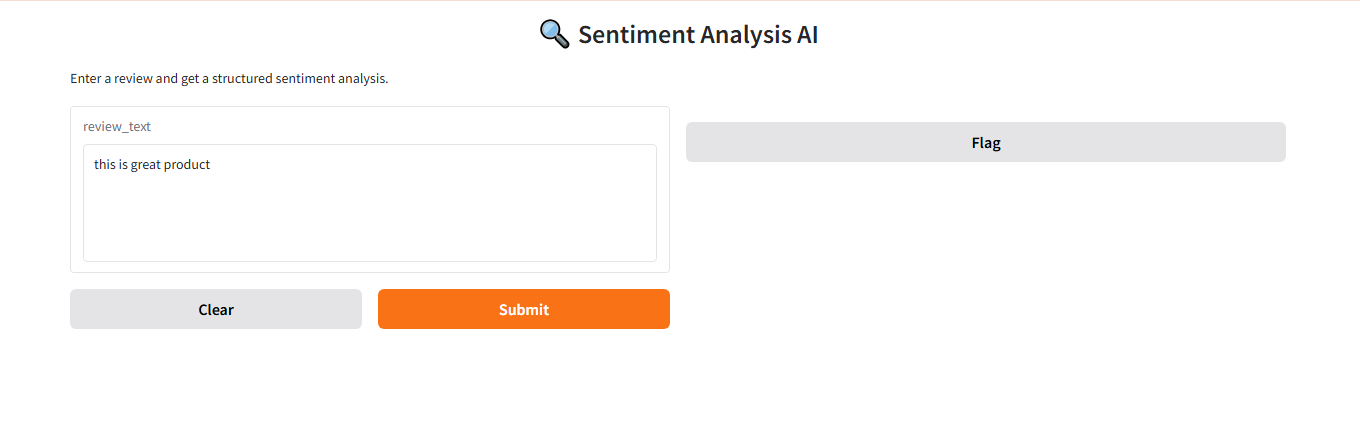